In [7]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
import scanpy as sc

from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scvi
import pandas as pd


In [8]:
### test whole data with RNA only 
path = "./data/datasets/BRCA-CAF/Mouse_Fibroblast_H5ad/S1_Fibroblast.h5ad"

adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [9]:
adata_mvi

AnnData object with n_obs × n_vars = 1080 × 75054
    obs: 'Unnamed: 0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'Sample', 'Disease_Group', 'percent.mt', 'percent.ribo', 'Doublet', 'Doublet_Scores', 'mouse.main', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.3', 'CytoTRACE', 'CytoTRACErank', 'monocle3_pseudotime', 'batch_id', 'modality'
    var: 'gene_ids', 'feature_types', 'modality', 'n_cells'

In [10]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='monocle3_pseudotime')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :9407
n_peaks:65647
fine tune is False
gate decoder initialization n_input 10, n_output 65647,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [11]:
model.module.set_finetune_params(0)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=1000, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1000/1000: 100%|██████████| 1000/1000 [07:32<00:00,  2.21it/s, loss=4.52e+04, v_num=1]


In [12]:
model.save("model_mouse_fibroblast_nocausal",overwrite=True)

In [14]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

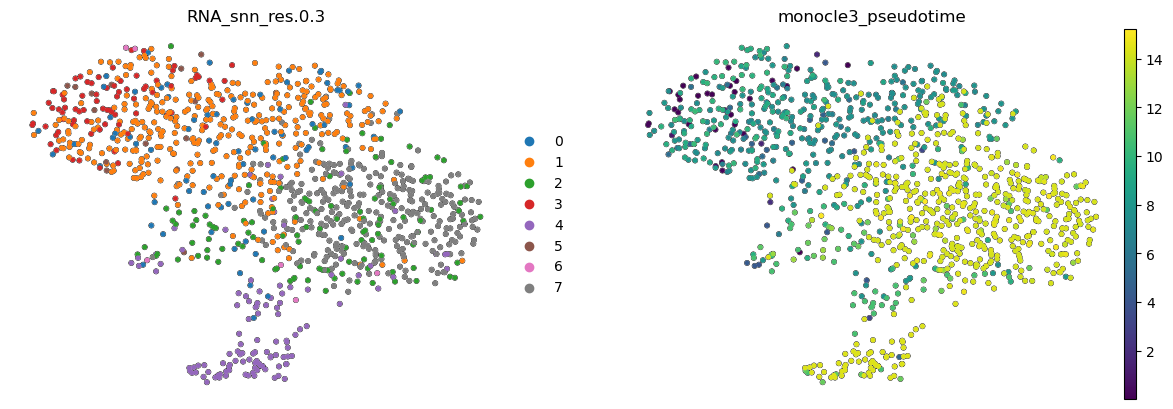

In [16]:
adata_mvi.obs['RNA_snn_res.0.3'] = adata_mvi.obs['RNA_snn_res.0.3'].astype(str).astype('category')
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)
sc.tl.umap(adata_mvi)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['RNA_snn_res.0.3', "monocle3_pseudotime"])

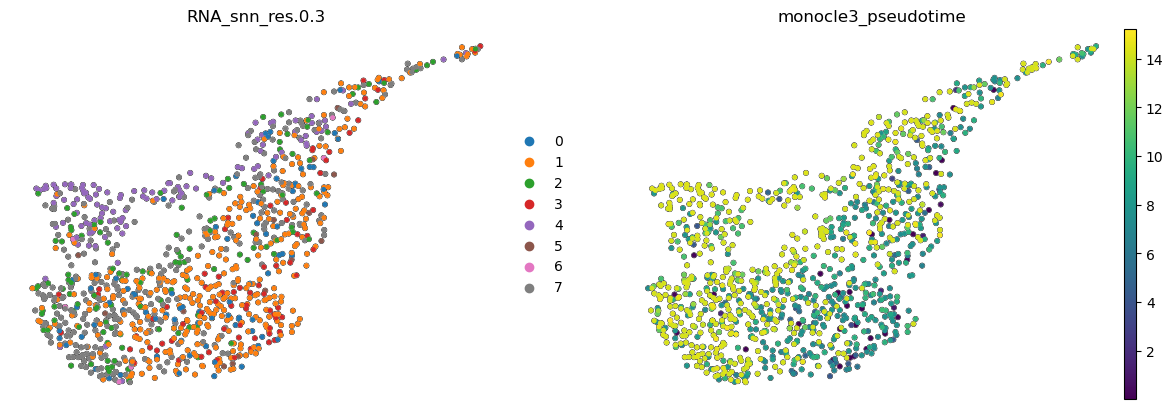

In [17]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)
sc.tl.umap(adata_mvi)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['ATAC_snn_res.0.3', "monocle3_pseudotime"])

In [20]:
model.module.alpha = 0.05
model.module.beta_2 = 1e7
model.module.beta_3 = 2e8
model.module.beta_1 = 1e7
print(model.module.alpha)

0.05


In [21]:
## finetune without L0
model.module.set_finetune_params(2)
model.module.set_train_params(expr_train=True, acc_train=True)
model.plan_kwargs = {"n_epochs_kl_warmup":300}
model.train(max_epochs=1000, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/1000:   0%|          | 0/1000 [00:00<?, ?it/s]reconst_loss 4.40E+04, nod_loss 8.79E+05
reconst_loss 4.64E+04, nod_loss 7.98E+05
Epoch 2/1000:   0%|          | 1/1000 [00:01<24:22,  1.46s/it, loss=8.84e+05, v_num=1]reconst_loss 4.40E+04, nod_loss 8.57E+05
reconst_loss 4.64E+04, nod_loss 7.71E+05
Epoch 3/1000:   0%|          | 2/1000 [00:02<17:39,  1.06s/it, loss=8.71e+05, v_num=1]reconst_loss 4.33E+04, nod_loss 8.17E+05
reconst_loss 4.72E+04, nod_loss 7.40E+05
Epoch 4/1000:   0%|          | 3/1000 [00:02<14:58,  1.11it/s, loss=8.56e+05, v_num=1]reconst_loss 4.59E+04, nod_loss 7.68E+05
reconst_loss 4.44E+04, nod_loss 8.40E+05
Epoch 5/1000:   0%|          | 4/1000 [00:03<13:52,  1.20it/s, loss=8.54e+05, v_num=1]reconst_loss 4.58E+04, nod_loss 8.01E+05
reconst_loss 4.46E+04, nod_loss 8.32E+05
Epoch 6/1000:   0%|          | 5/1000 [00:04<13:14,  1.25it/s, loss=8.55e+05, v_num=1]reconst_loss 4.50E+04, nod_loss 7.65E+05
reconst_loss 4.55E+04, nod_loss 8.37E+05
Epoch 7/1000:   1%|     

In [23]:
model.save("model_mouse_fibroblast_causal005",overwrite=True)

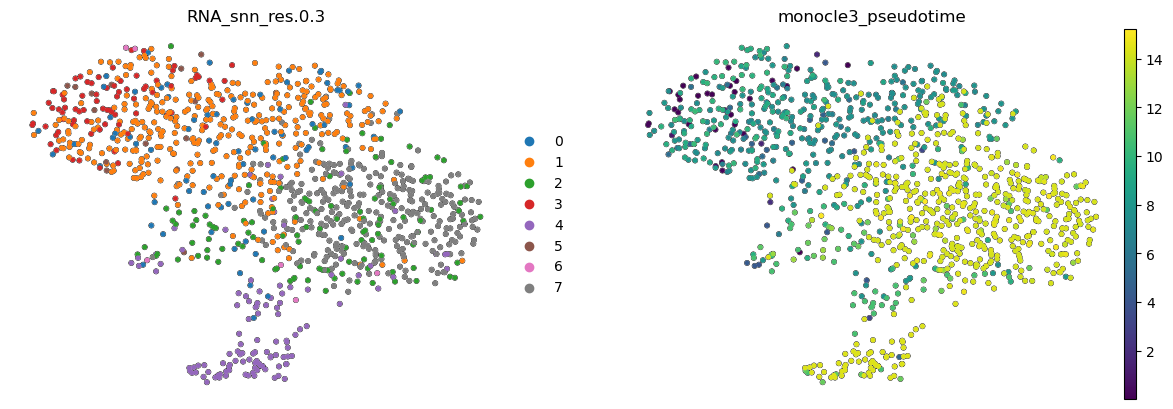

In [24]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)
sc.tl.umap(adata_mvi)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['RNA_snn_res.0.3', "monocle3_pseudotime"])

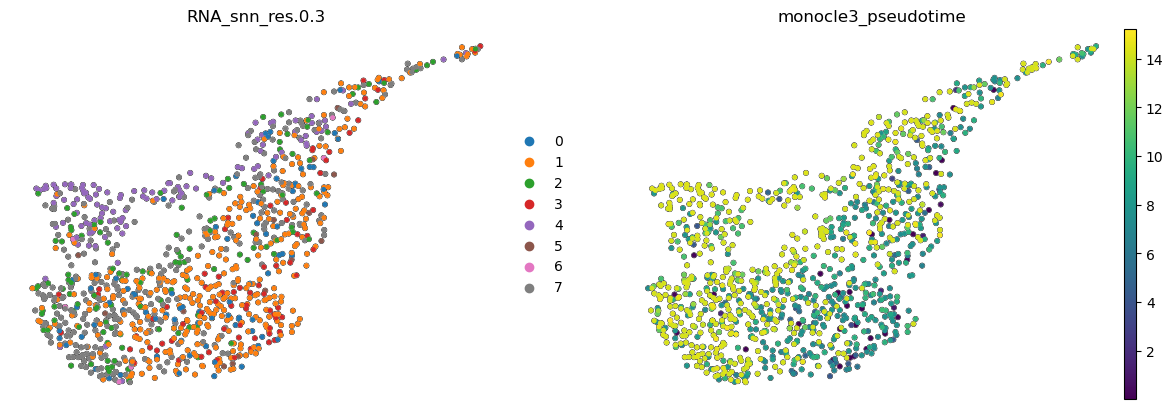

In [25]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)
sc.tl.umap(adata_mvi)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['ATAC_snn_res.0.3', "monocle3_pseudotime"])

In [26]:
## finetune without L0
model.train(max_epochs=500, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]reconst_loss 4.55E+04, nod_loss 6.29E+05
reconst_loss 4.41E+04, nod_loss 4.59E+05
Epoch 2/500:   0%|          | 1/500 [00:00<06:04,  1.37it/s, loss=5.89e+05, v_num=1]reconst_loss 4.38E+04, nod_loss 5.15E+05
reconst_loss 4.59E+04, nod_loss 5.73E+05
Epoch 3/500:   0%|          | 2/500 [00:01<06:09,  1.35it/s, loss=5.89e+05, v_num=1]reconst_loss 4.56E+04, nod_loss 5.05E+05
reconst_loss 4.39E+04, nod_loss 5.93E+05
Epoch 4/500:   1%|          | 3/500 [00:02<06:09,  1.34it/s, loss=5.9e+05, v_num=1] reconst_loss 4.50E+04, nod_loss 5.65E+05
reconst_loss 4.45E+04, nod_loss 5.31E+05
Epoch 5/500:   1%|          | 4/500 [00:02<06:06,  1.35it/s, loss=5.91e+05, v_num=1]reconst_loss 4.49E+04, nod_loss 5.19E+05
reconst_loss 4.46E+04, nod_loss 5.75E+05
Epoch 6/500:   1%|          | 5/500 [00:03<06:06,  1.35it/s, loss=5.91e+05, v_num=1]reconst_loss 4.44E+04, nod_loss 5.48E+05
reconst_loss 4.52E+04, nod_loss 5.15E+05
Epoch 7/500:   1%|          | 6/500 

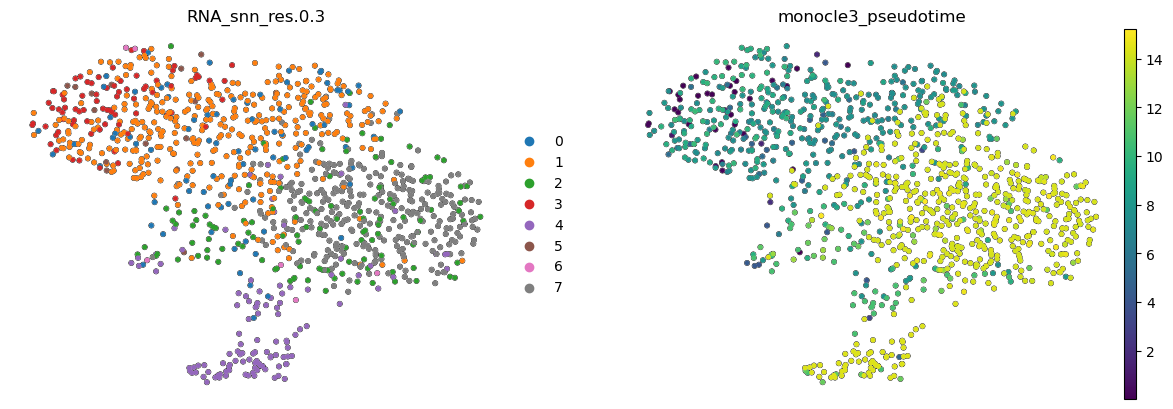

In [28]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)
sc.tl.umap(adata_mvi)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['RNA_snn_res.0.3', "monocle3_pseudotime"])

In [29]:
model.save("model_mouse_fibroblast_causal005_1500",overwrite=True)